# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from IPython.display import Image, SVG

sns.set_theme()

# Data Loading

In [3]:

def load_all_experiments(experiment_folder="./experiments"):
    """
    Given a folder with a number of experiments, where each experiment has one pickled dataframe, load and return all
    dataframes.

    """
    # TODO: Read from configs, too, and insert these values as metadata.
    experiment_folder = Path(experiment_folder)
    if not experiment_folder.is_dir():
        raise ValueError(f"Not a valid folder: {experiment_folder}")

    all_frames = {}
    for d in tqdm(Path(experiment_folder).iterdir(), "Scanning all experiments"):
        if d.is_dir():
            gen_pkl = d / "generations.pkl"
            if gen_pkl.is_file():
                df = pd.read_pickle(gen_pkl)
                df["experiment"] = d.name
                prev_index = df.index.names
                df.reset_index(inplace=True)
                df.set_index(["experiment"] + prev_index, inplace=True)
                all_frames[d.name] = df
    return all_frames


In [4]:
experiment_map = load_all_experiments()
print(f"Found {len(experiment_map)} experiments.")

Scanning all experiments: 427it [00:02, 179.66it/s]

Found 387 experiments.


# Collate All Experiments Together

In [5]:
experiments = pd.concat(experiment_map.values())

In [6]:
# Add a "Trial" column by parsing the experiment name.
# expcol = experiments.index.get_level_values("experiment")
experiments.reset_index(inplace=True)
trialcol = experiments["experiment"].str.extract("(.+?)(-([0-9]))?$")[2].apply(
    lambda x: 0 if (x is None or x is np.nan) else int(x))
experiments.insert(1, "trial", trialcol)
experiments.set_index(["experiment", "trial", "generation"], inplace=True)

In [7]:
experiments

num_species  best_genome  \
experiment             trial generation                             
walker-grow150-prune50 0     1                     5           10   
                             2                     5          159   
                             3                     5          374   
                             4                     5          374   
                             5                     5          667   
...                                              ...          ...   
walker-hc-grow-only    0     196                   4        26829   
                             197                   4        26829   
                             198                   4        25830   
                             199                   4        26829   
                             200                   4        26829   

                                         conn_add_prob  conn_delete_prob  \
experiment             trial generation                                    
walker-grow150-prune50 0     1                     0.9               0.1   
                             2                     0.9               0.1   
                             3                     0.9               0.1   
                             4                     0.9               0.1   
                             5                     0.9               0.1   
...                                                ...               ...   
walker-hc-grow-only    0     196                   0.1               0.1   
                             197                   0.1               0.1   
                             198                   0.1               0.1   
                             199                   0.1               0.1   
                             200                   0.1               0.1   

                                         node_add_prob  node_delete_prob  \
experiment             trial generation                                    
walker-grow150-prune50 0     1                     0.9               0.1   
                             2                     0.9               0.1   
                             3                     0.9               0.1   
                             4                     0.9               0.1   
                             5                     0.9               0.1   
...                                                ...               ...   
walker-hc-grow-only    0     196                   0.1               0.1   
                             197                   0.1               0.1   
                             198                   0.1               0.1   
                             199                   0.1               0.1   
                             200                   0.1               0.1   

                                         fitness.count  fitness.mean  \
experiment             trial generation                                
walker-grow150-prune50 0     1                   150.0   -126.339797   
                             2                   151.0   -118.952484   
                             3                   150.0   -113.537089   
                             4                   150.0   -117.711997   
                             5                   150.0   -114.599896   
...                                                ...           ...   
walker-hc-grow-only    0     196                   NaN    -93.173308   
                             197                   NaN    -97.054170   
                             198                   NaN    -98.526163   
                             199                   NaN   -100.393751   
                             200                   NaN    -97.578916   

                                         fitness.std  fitness.min  ...  \
experiment             trial generation                            ...   
walker-grow150-prune50 0     1             23.289160  -196.549539  ...   
      

# Plotting Functions

In [8]:
import warnings


def get_stat_name(var):
    names = var.split(".")
    return names[1] if len(names) > 1 else "value"


def get_variable_name(var):
    return var.split(".")[0]


def plot_runs(df, vars_to_plot, **kwargs):
    df = df.melt(value_vars=vars_to_plot, ignore_index=False)
    df["stat"] = df["variable"].apply(get_stat_name)
    df["variable"] = df["variable"].apply(get_variable_name)
    df = df[~df.value.isnull()]

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="generation",
            y="value",
            row="variable",
            hue="stat",
            # palette="tab10",
            kind="line",
            height=3,
            aspect=3,
            facet_kws=dict(sharey=False, gridspec_kws=dict(top=0.90)),
            **kwargs
        )
    # Adjust labels.
    fg.set_axis_labels("Generation", "Value")
    return fg


def plot_experiment(df, expname, vars_to_plot, exptitle=None):
    if not exptitle:
        exptitle = expname
    expcol = df.index.get_level_values("experiment")
    df = df.loc[expcol == expname, :]
    fg = plot_runs(df, vars_to_plot, errorbar="sd")
    fg.figure.suptitle(f"Experiment: {exptitle}")
    plt.show()
    return fg


def plot_trials(df, expname, vars_to_plot, exptitle=None, summarize=True):
    if not exptitle:
        exptitle = expname
    expcol = df.index.get_level_values("experiment")
    df = df.loc[expcol.str.fullmatch(expname + "(-[0-9])?$")]
    kwargs = {}
    if summarize:
        kwargs["errorbar"] = "sd"
    else:
        kwargs["estimator"] = None
        kwargs["units"] = "trial"
    fg = plot_runs(df, vars_to_plot, **kwargs)
    fg.figure.suptitle(f"Experiment: {exptitle}")
    plt.show()
    return fg


# Analysis

In [9]:
best_performers = experiments.groupby("experiment").max("fitness.max")["fitness.max"].sort_values(ascending=False)
best_performers
# TODO: Get last value from each group.

experiment
walker-high-struct-mutation-c90n30-3          305.556151
walker-init0.1-high-struct-mutation-single    305.080747
walker-high-struct-mutation-4                 304.867974
walker-high-struct-mutation-9                 304.560813
walker-init0.1-grow-always-c90n30             303.538692
                                                 ...    
walker-hc-grow-prune-spec2.5-8                -47.529169
walker-hc-grow-always-6                       -49.172975
walker-hc-grow-always-1                       -52.389561
walker-hc-grow-always-8                       -54.915515
walker-hc-grow-always-2                       -71.866755
Name: fitness.max, Length: 387, dtype: float64

In [10]:
best_on_average = experiments.groupby("experiment").max("fitness.mean")["fitness.mean"].sort_values(ascending=False)
best_on_average

experiment
walker-init1.0-prune-only-1             138.608599
walker-baseline-9                       129.011001
walker-grow-always-c90n30-5             125.906470
walker-high-struct-mutation-3           121.913489
walker-high-struct-mutation-c90n30-7    119.700530
                                           ...    
walker-hc-grow-only-3                  -105.600963
walker-hc-grow-always-4                -105.819904
walker-hc-grow-only-6                  -106.594756
walker-hc-grow-always-3                -106.917796
walker-hc-grow-always-7                -107.481140
Name: fitness.mean, Length: 387, dtype: float64

In [13]:
# Performance Summary Over a Grouping of Experiments

# target = "walker(-init0.1)?-high-struct(ural)?-mut"
# target = "walker(-init0.1)?-grow[0-9]*-prune[0-9]*"  # all grow-prune trials
target = "walker-hc2-.*"
expcol = best_performers.index.get_level_values("experiment")
# trials = best_performers.loc[expcol.str.contains(target)]
trials = best_performers.loc[expcol.str.contains(target + "-?[0-9]?$")]
print(f"Avg {trials.mean():.2f} (std {trials.std():.2f})")
trials

Avg 120.33 (std 21.69)


experiment
walker-hc2-grow-prune-spec2.5-3    166.990921
walker-hc2-baseline-6              160.952419
walker-hc2-baseline-7              157.466278
walker-hc2-grow-prune-c90n30-6     157.166776
walker-hc2-grow-always             155.630764
                                      ...    
walker-hc2-grow-only-6              83.852610
walker-hc2-high-mutrate-3           83.086157
walker-hc2-high-mutrate-9           81.704789
walker-hc2-grow-prune-8             66.344151
walker-hc2-high-mutrate-7           66.114020
Name: fitness.max, Length: 80, dtype: float64

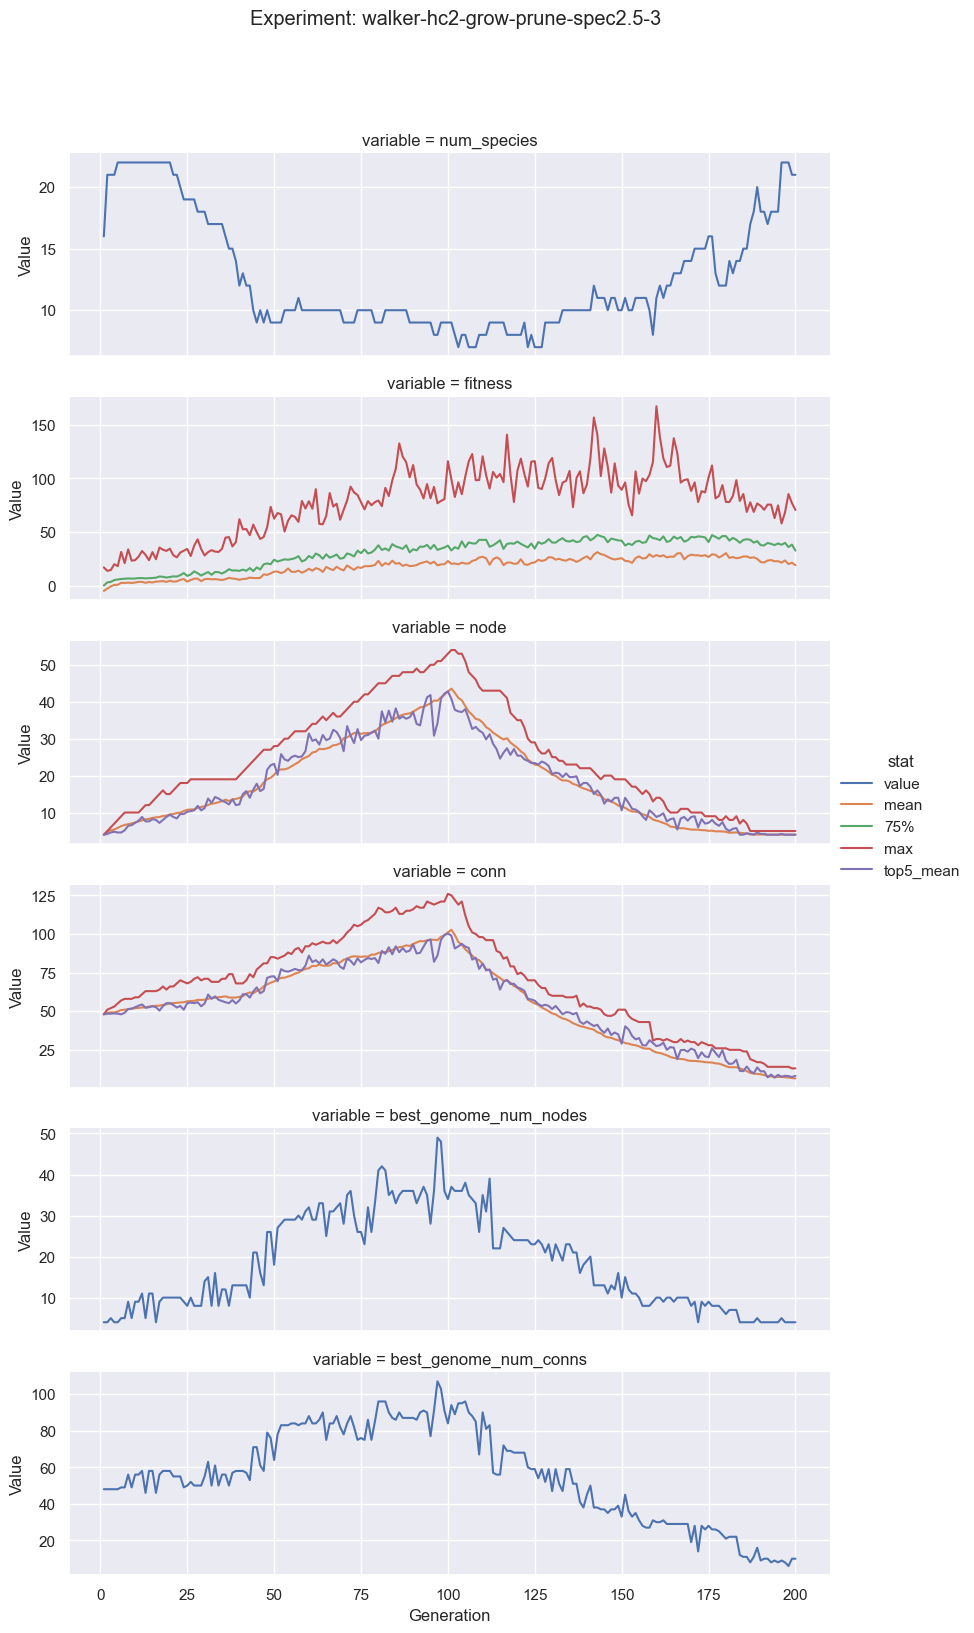

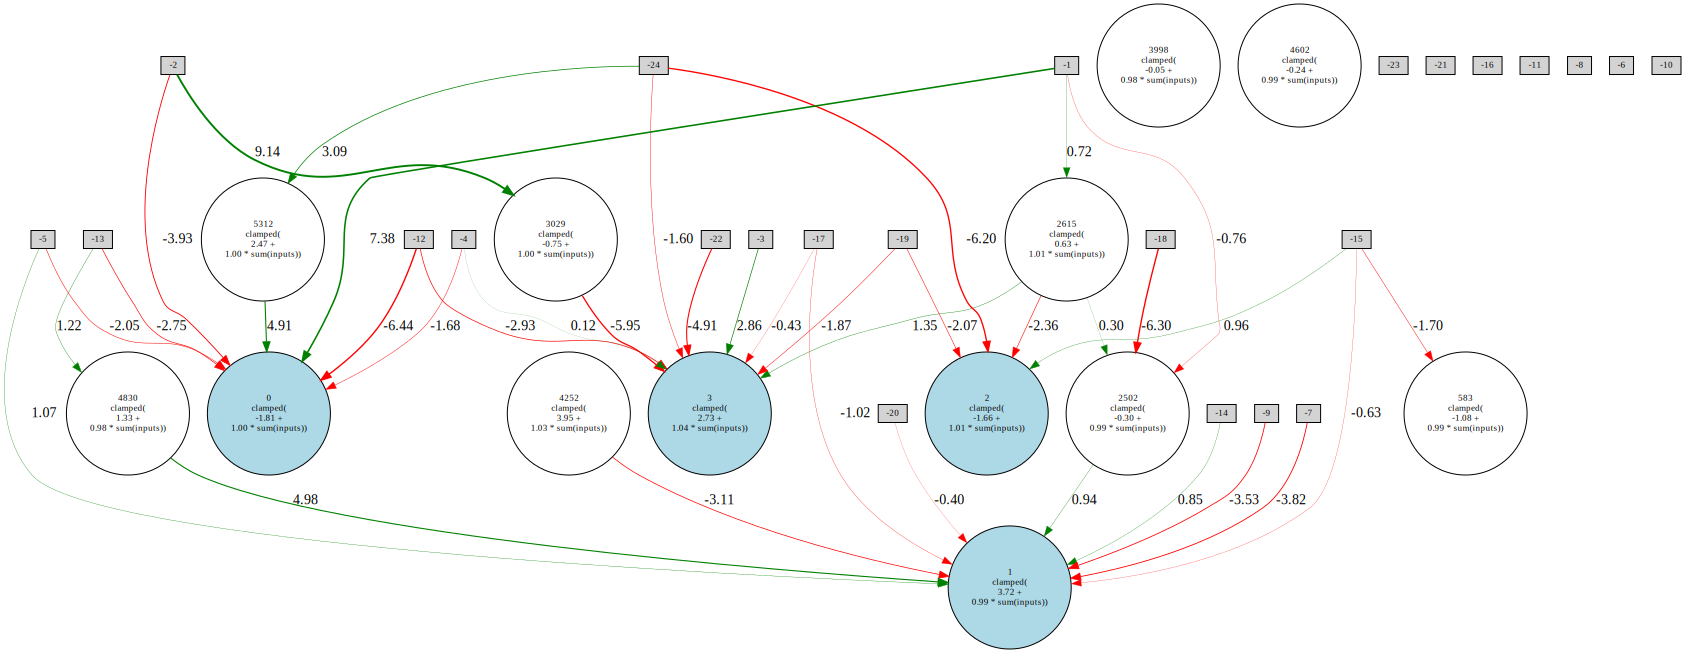

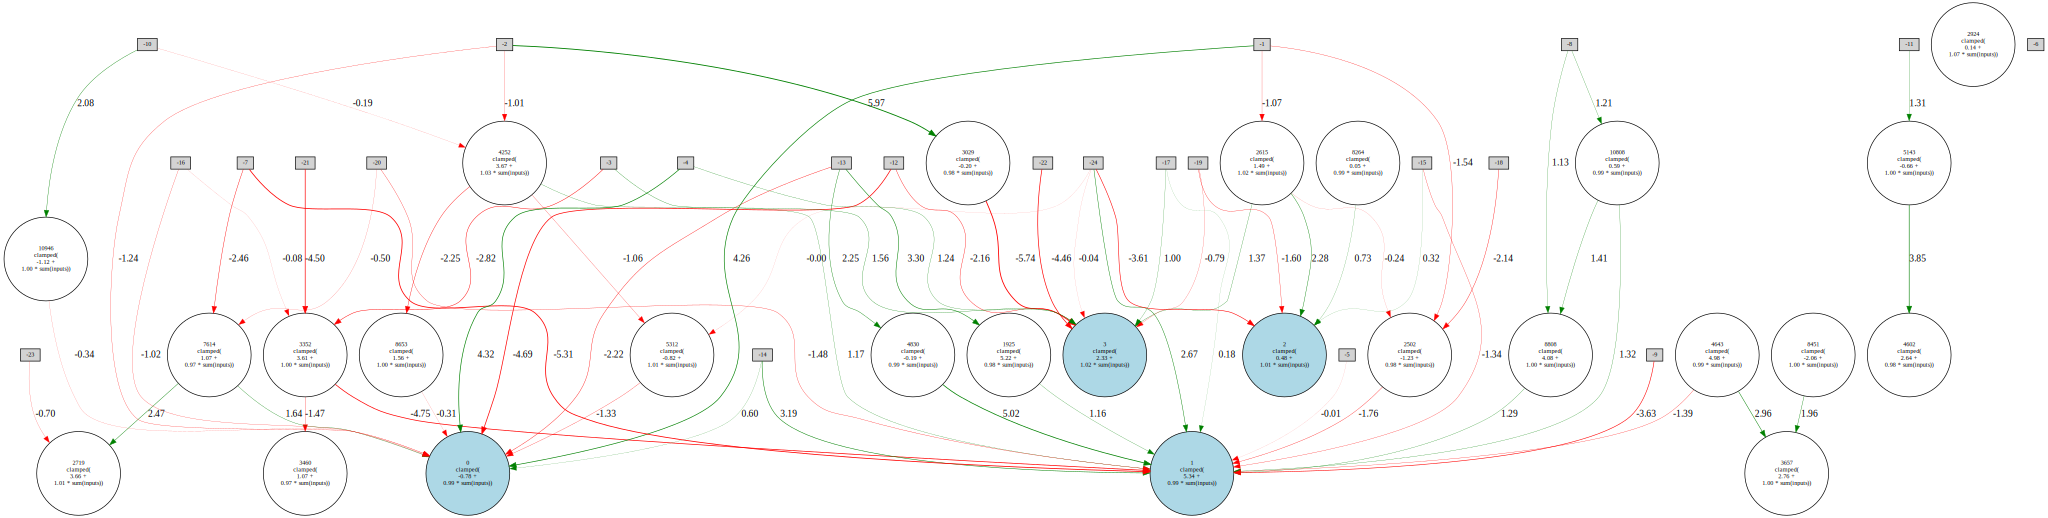

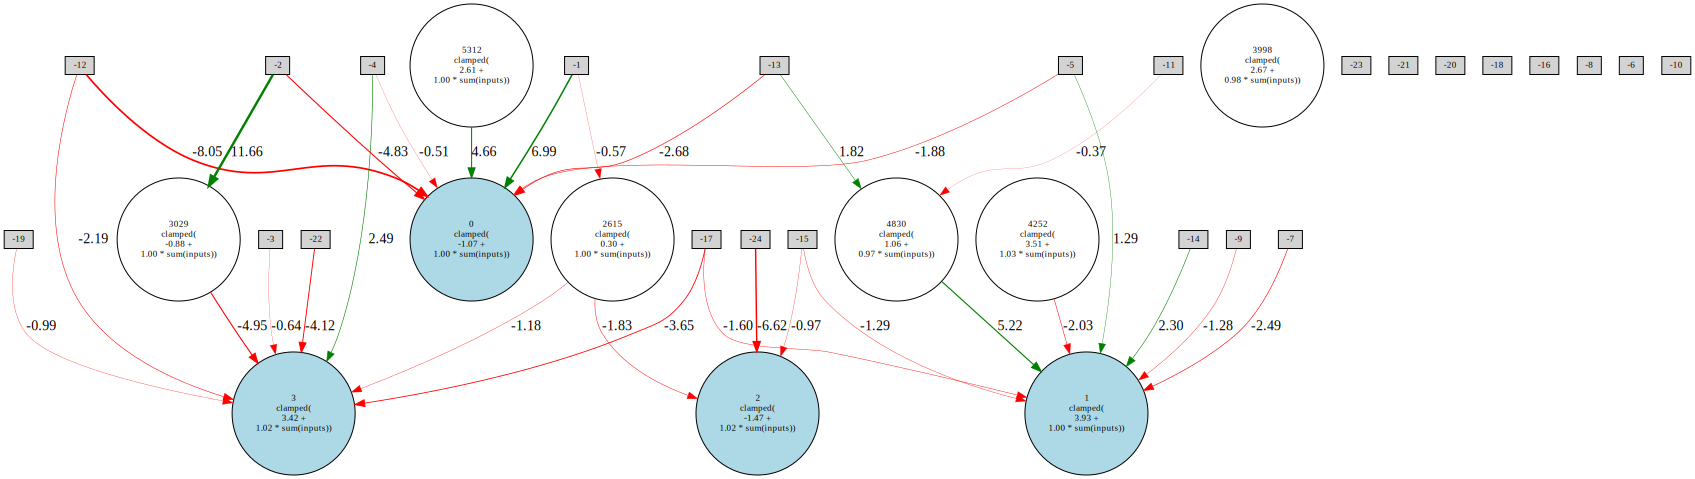

In [14]:
# expname = best_performers.index[2]
expname = trials.index[0]
# expname = "walker-grow-prune-9"
cols_to_plot = ["num_species", "fitness.mean", "fitness.75%", "fitness.max", "node.mean", "node.max", "node.top5_mean",
                "conn.mean", "conn.max", "conn.top5_mean", "best_genome_num_nodes", "best_genome_num_conns"]
plot_experiment(experiments, expname, cols_to_plot)
display(SVG("experiments/" + expname + "/winner-0-net-pruned.gv.svg"))
display(SVG("experiments/" + expname + "/winner-1-net-pruned.gv.svg"))
display(SVG("experiments/" + expname + "/winner-2-net-pruned.gv.svg"))

In [586]:
# Group results by experiment; only experiments with at least 3 trials.
from scipy.stats import mannwhitneyu

expcol = best_performers.index.get_level_values("experiment")
namewidth = max(len(n) for n in expcol)
baseline_trials = best_performers.loc[expcol.str.fullmatch("walker-baseline(-[0-9])?$")]
sparse_baseline_trials = best_performers.loc[expcol.str.fullmatch("walker-init0.1-baseline(-[0-9])?$")]
grow_prune_trials = best_performers.loc[expcol.str.fullmatch("walker-grow-prune(-[0-9])?$")]
sparse_grow_prune_trials = best_performers.loc[expcol.str.fullmatch("walker-init0.1-grow-prune(-[0-9])?$")]

# Find each unique string that is followed by nothing or by a single digit indicating trial number.
all_trials = {}
for n, g in expcol.str.extract("(.+?)(-[0-9])?$").groupby(0):
    if len(g) >= 3:
        trials = best_performers.loc[expcol.str.fullmatch(n + "(-[0-9])?$")]
        all_trials[n] = trials

for n, trials in sorted(all_trials.items(), key=lambda e: e[1].mean(), reverse=True):
    pval = mannwhitneyu(trials, baseline_trials, alternative="greater").pvalue
    # pval = mannwhitneyu(trials, sparse_baseline_trials, alternative="greater").pvalue
    # pval = mannwhitneyu(trials, grow_prune_trials, alternative="less").pvalue
    # pval = mannwhitneyu(trials, sparse_grow_prune_trials, alternative="less").pvalue
    print(f"{n:{namewidth}} {trials.mean():5.1f} ({trials.std():5.1f} std) ({pval:4.3f} p-value)")

walker-high-struct-mutation                         280.3 ( 24.0 std) (0.003 p-value)
walker-high-struct-mutation-c90n30                  269.2 ( 41.2 std) (0.016 p-value)
walker-high-structural-mutation                     262.4 ( 24.6 std) (0.108 p-value)
walker-grow-prune-c90n30                            261.9 ( 25.6 std) (0.044 p-value)
walker-high-struct-mutation-always-single           256.8 (  8.5 std) (0.143 p-value)
walker-grow-always-c90n30                           255.2 ( 23.4 std) (0.121 p-value)
walker-init1.0-prune-only                           253.2 (  6.0 std) (0.185 p-value)
walker-high-struct-mutation-always                  252.1 ( 27.6 std) (0.346 p-value)
walker-grow50-prune150                              250.6 ( 41.0 std) (0.346 p-value)
walker-init1.0-high-struct-mutation                 245.2 ( 20.7 std) (0.346 p-value)
walker-grow-prune-spec2.5                           242.3 ( 30.1 std) (0.633 p-value)
walker-baseline                                     23

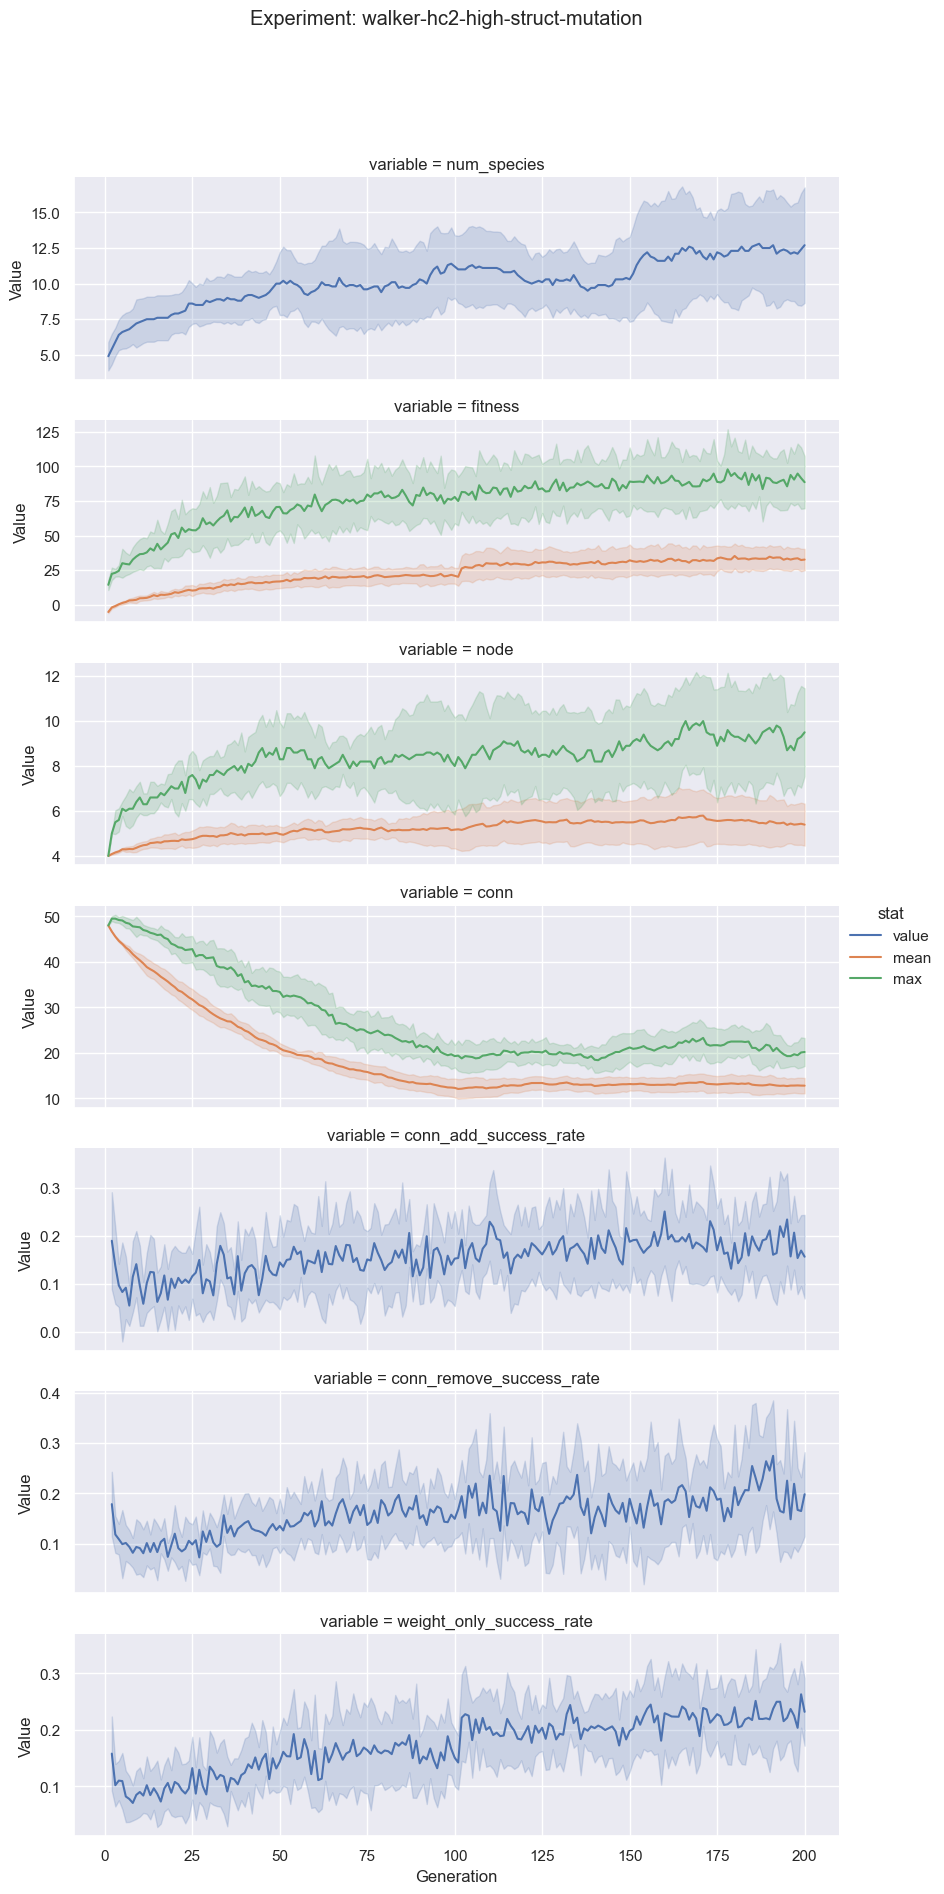

In [17]:
expname = "walker-hc2-high-struct-mutation"
# cols_to_plot = ["num_species", "fitness.mean", "fitness.75%", "fitness.max", "node.mean", "node.max", "node.top5_mean",
#                 "conn.mean", "conn.max", "conn.top5_mean", "best_genome_num_nodes", "best_genome_num_conns"]
cols_to_plot = ["num_species", "fitness.mean", "fitness.max", "node.mean", "node.max", "conn.mean", "conn.max",
                "conn_add_success_rate", "conn_remove_success_rate", "weight_only_success_rate"]
# cols_to_plot = ["conn.mean", "conn.max", "best_genome_num_conns"]
plot_trials(experiments, expname, cols_to_plot, summarize=True)

In [584]:
target = "walker-grow-prune"
expcol = experiments.index.get_level_values("experiment")
gencol = experiments.index.get_level_values("generation")
matched = expcol.str.fullmatch(target + "(-[0-9])?$")
filtered = experiments.loc[matched & (50 <= gencol) & (gencol < 100)]
print(expcol[matched].unique())
print(len(filtered))
print(filtered)
cols = filtered.columns[filtered.columns.str.contains("_rate")]
colwidth = max(len(c) for c in cols) + 1
means = {"add_success_rate": [], "remove_success_rate": []}
stds = {"add_success_rate": [], "remove_success_rate": []}
for metric in cols:
    for r in means:
        if r in metric:
            means[r].append(filtered[metric].mean())
            stds[r].append(filtered[metric].std())
    print(f"{metric:{colwidth}}= {filtered[metric].mean():5.1%} (std {filtered[metric].std() * 100:4.1f})")

for r in means:
    print(f"{r:{colwidth}}= {np.mean(means[r]):5.1%} (std {np.mean(stds[r]) * 100:4.1f})")

Index(['walker-grow-prune-7', 'walker-grow-prune-9', 'walker-grow-prune-8',
       'walker-grow-prune-6', 'walker-grow-prune-1', 'walker-grow-prune',
       'walker-grow-prune-4', 'walker-grow-prune-3', 'walker-grow-prune-2',
       'walker-grow-prune-5'],
      dtype='object', name='experiment')
500
                                      num_species  best_genome  conn_add_prob  \
experiment          trial generation                                            
walker-grow-prune-7 7     50                    4         5091            0.9   
                          51                    4         5091            0.9   
                          52                    4         5091            0.9   
                          53                    4         5091            0.9   
                          54                    4         5091            0.9   
...                                           ...          ...            ...   
walker-grow-prune-5 5     95                    4 

In [385]:
left = filtered["conn_add_success_rate"].dropna()
right = filtered["conn_remove_success_rate"].dropna()
print(len(left))
pval = mannwhitneyu(left, right).pvalue
print(f"{left.mean():.1%} ({left.std() * 100:.1f} std) vs. {right.mean():.1%} ({right.std() * 100:.1f} std):"
      f" {pval} p-value")

7671
6.3% (9.5 std) vs. 5.9% (9.3 std): 1.0391095457111285e-16 p-value


# Scratch Area

In [22]:
trials

experiment
walker-hc-high-struct-mutation-9     1.813937
walker-hc-high-struct-mutation-3    -2.672295
walker-hc-high-struct-mutation-1    -3.114181
walker-hc-high-struct-mutation-2    -3.296769
walker-hc-high-struct-mutation-4    -3.316063
                                      ...    
walker-hc-grow-prune-spec2.5-8     -47.529169
walker-hc-grow-always-6            -49.172975
walker-hc-grow-always-1            -52.389561
walker-hc-grow-always-8            -54.915515
walker-hc-grow-always-2            -71.866755
Name: fitness.max, Length: 70, dtype: float64

In [328]:
# Listing which experiments don't have new metrics values.
frozenset(experiments.loc[experiments["pop_size"].isnull()].index.get_level_values("experiment"))

frozenset({'walker-grow-always',
           'walker-grow-always-2',
           'walker-grow-always-c90n30',
           'walker-grow-always-single',
           'walker-grow-only',
           'walker-grow-only-2',
           'walker-grow-only-c90n30',
           'walker-grow-only-single',
           'walker-grow-prune',
           'walker-grow-prune-2',
           'walker-grow-prune-c90n30',
           'walker-grow-prune-single',
           'walker-grow150-prune50',
           'walker-grow50-prune150',
           'walker-high-struct-mutation-always',
           'walker-high-struct-mutation-always-2',
           'walker-high-struct-mutation-always-single',
           'walker-high-struct-mutation-c90n30',
           'walker-high-structural-mutation',
           'walker-high-structural-mutation-2',
           'walker-init0.1-grow-always',
           'walker-init0.1-grow-always-c90n30',
           'walker-init0.1-grow-always-single',
           'walker-init0.1-grow-only',
           'walker-

In [449]:
[k for k, v in all_trials.items() if len(v) > 3]

['walker-baseline',
 'walker-grow-always-c90n30',
 'walker-grow-prune',
 'walker-grow-prune-spec2.5',
 'walker-high-struct-mutation',
 'walker-high-struct-mutation-c90n30',
 'walker-init0.1-baseline',
 'walker-init0.1-grow-always',
 'walker-init0.1-grow-only',
 'walker-init0.1-grow-prune']